## EDA - House price

This EDA aim at understanding at how house price are fixed on the market.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from rich import print
from rich.console import Console
from rich.traceback import install
from rich.markdown import Markdown
install() 

# Set seaborn style
sns.set_style("whitegrid")
%matplotlib inline

In [25]:
# Import Housing.csv

df = pd.read_csv('Housing.csv')

In [26]:
def type_column(col, df):
    if df[col].nunique() == 2:
        type = 'boolean'
    elif df[col].nunique() < 10:
        type = 'categorical'
    elif df[col].dtype in ['int64', 'float64']:
        type = 'numerical'
    elif df[col].dtype in ['datetime64[ns]']:
        type = 'date'
    else: type = 'unknown'

    return type

def type_columns(df):
    type_col = dict()

    for col in df.columns:
        type_col.setdefault(type_column(col, df), []).append(col)
    
    return type_col

# type_columns(df)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


Data Description                                                  

There are 545 rows and 13 columns in the dataset                                                                   

The columns are :                                                                                                  

 • numerical : price, area                                                                                         
 • categorical : bedrooms, bathrooms, stories, parking, furnishingstatus                                           
 • boolean : mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea                             

                                                      Columns                                                      

price                                                                                                              

 • Number of missing values : 0                                                                                    
 • Number of unique values : 219                                                                                   
 • Mean : 4766729.247706422                                                                                        
 • Median : 4340000.0                                                                                              
 • Minimum : 1750000                                                                                               
 • Maximum : 13300000                                                                                              

area                                                                                                               

 • Number of missing values : 0                                                                                    
 • Number of unique values : 284                                                                                   
 • Mean : 5150.54128440367                                                                                         
 • Median : 4600.0                                                                                                 
 • Minimum : 1650                                                                                                  
 • Maximum : 16200                                                                                                 

bedrooms                                                                                                           

 • Number of missing values : 0                                                                                    
 • Number of unique values : 6                                                                                     
 • Categories : 1, 2, 3, 4, 5, 6                                                                                   

bathrooms                                                                                                          

 • Number of missing values : 0                                                                                    
 • Number of unique values : 4                                                                                     
 • Categories : 1, 2, 3, 4                                                                                         

stories                                                                                                            

 • Number of missing values : 0                                                                                    
 • Number of unique values : 4                                                                                     
 • Categories : 1, 2, 3, 4                                                                                         

mainroad                                                                                                           

 • Number of missing values : 0                                                          

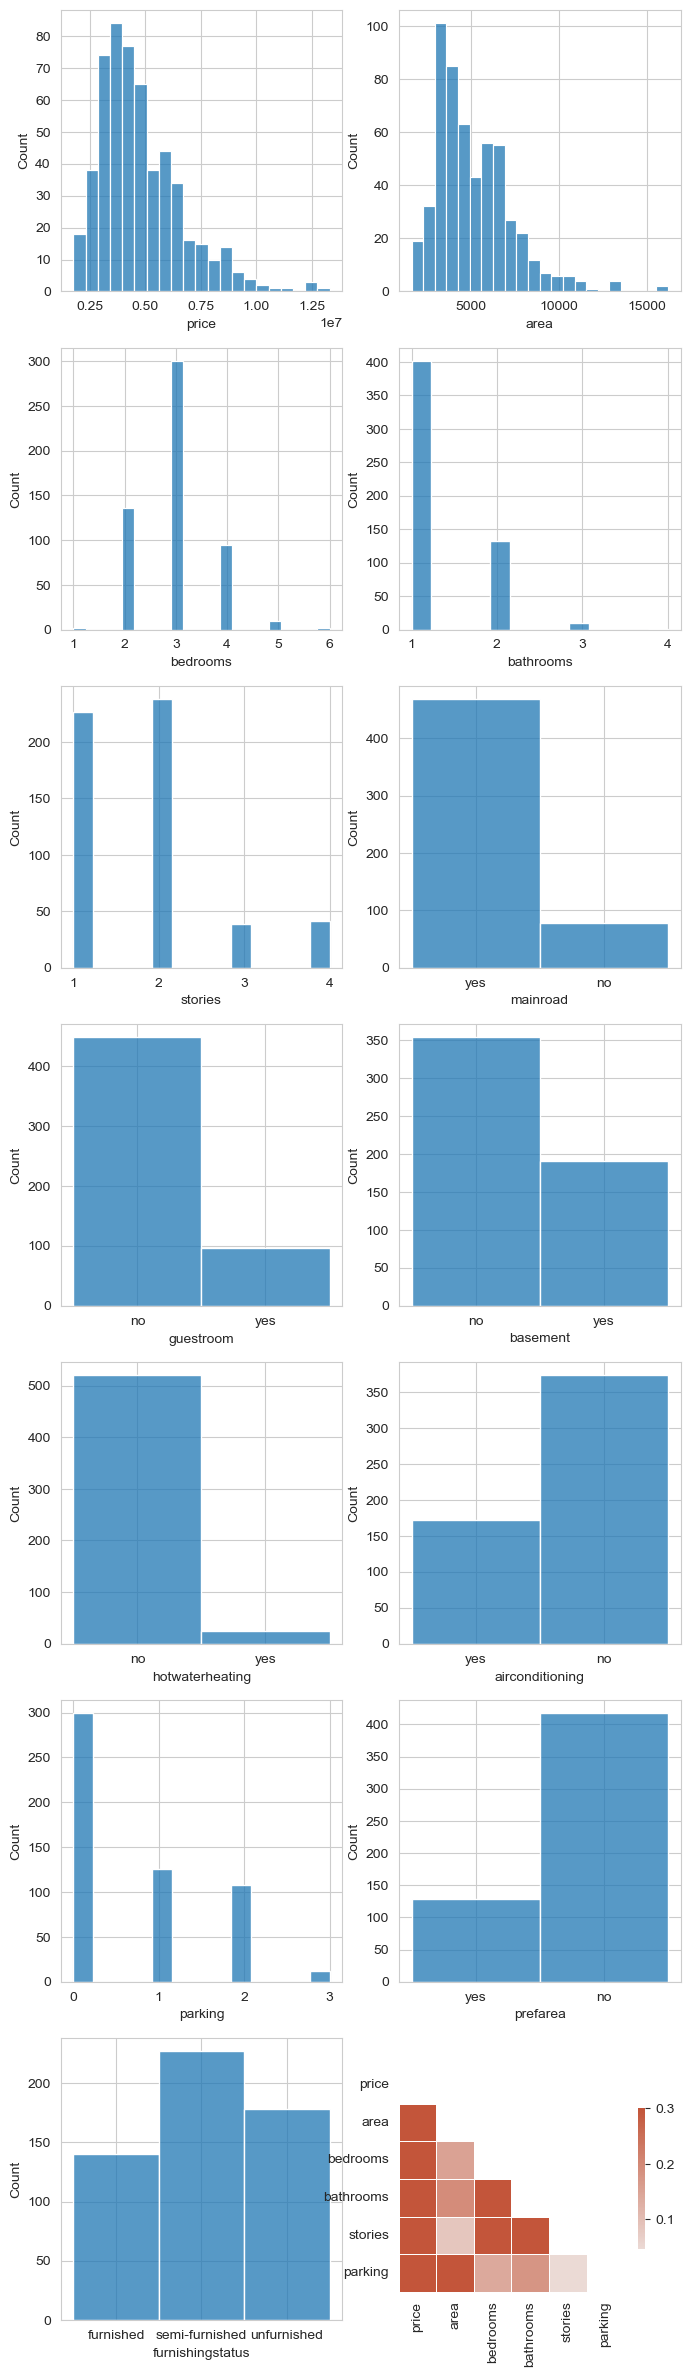

In [29]:
def describe_data(df):
    
    display(df.head())

    m, n = df.shape
    describe = f"""
## Data Description
There are **{m}** rows and **{n}** columns in the dataset

The columns are :
"""
    type_col = type_columns(df)
    for type, columns in type_col.items():
        describe += f"""- **{type}** : {', '.join(columns)} \n"""
    
    describe += """### Columns \n"""
    for col in df.columns:
        type = type_column(col, df)
        describe += f""" 
**{col}** 
- Number of missing values : **{df[col].isnull().sum()}**
- Number of unique values : **{df[col].nunique()}**
"""
        if type == 'numerical':
            describe += f"""- Mean : **{df[col].mean()}**
- Median : **{df[col].median()}**
- Minimum : **{df[col].min()}**
- Maximum : **{df[col].max()}**
"""
        if type == 'categorical':
            describe += f"""- Categories : **{', '.join(map(str, sorted(df[col].unique())))}**
"""
        if type == 'boolean':
            values = df[col].value_counts()
            describe += f"""- Categories : **{', '.join(map(str, sorted(values.index.to_list())))}**
"""    
    fig, ax = plt.subplots(math.ceil(n/2), 2, figsize = (8, 30))

    # Plotting distribution of columns
    for i, col in enumerate(df.columns):
        sns.histplot(df[col], ax=ax[i//2, i%2])
    
    # Plotting correlation matrix
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax[-1, -1])

    return Markdown(describe)

console = Console()
console.print(describe_data(df))

The correlation matrix tend to show that the correlation between features and price is strong. This is a good sign for creating a regression model on data to predict price.

## Prediction model

In [83]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

In [71]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [73]:
## Data Preprocessing : StandardScaler, OneHotEncoder

Y = df['price']
X = df.drop('price', axis = 1)
type = type_columns(X)

# Boolean columns
for col in type['boolean']:
    # yes = 1, no = 0
    X[col] = X[col].map({'yes': 1, 'no': 0, 1 : 1, 0 : 0})

# Categorical columns : OneHotEncoder
for col in type['categorical']:
    X = pd.concat([X, pd.get_dummies(X[col], prefix = col)], axis = 1)
    X.drop(col, axis = 1, inplace = True)

# Numerical columns : StandardScaler
for col in type['numerical']:
    X[col] = StandardScaler().fit_transform(X[[col]])

X.head()

,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,bedrooms_1,bedrooms_2,bedrooms_3,...,stories_2,stories_3,stories_4,parking_0,parking_1,parking_2,parking_3,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,1.046726,1,0,0,0,1,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
1,1.757010,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
2,2.218232,1,0,1,0,0,1,0,0,1,...,1,0,0,0,0,1,0,0,1,0
3,1.083624,1,0,1,0,1,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
4,1.046726,1,1,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [77]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [44]:
# Fitting Simple Linear Regression to the Training set

regressor = LinearRegression()

folds = KFold(n_splits = 4, shuffle = True)
cv_res = cross_validate(regressor, X_train, y_train, cv = folds, scoring = 'r2')
print(cv_res['test_score'].mean())


# regressor.fit(X_train, y_train)
# Predicting the Test set results
# Y_predict = regressor.predict(X_test)
# print(f"R2 score : {r2_score(y_test, Y_predict)}")

0.6088344128088823

In [38]:
regressors = [
    LinearRegression(),
    Lasso(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
]

params = [
      [ {} ], 
      [ {   'alpha': np.linspace(1e-3, 10000, 10), 
            # 'max_iter' : [10000000]
      }],
      [ {   'n_estimators': [5,30,60], # number of trees in the random forest
            'max_features' : [1.0],
            
            'max_depth': [int(x) for x in np.linspace(10, 60, num = 3)], # maximum number of levels allowed in each decision tree
            'min_samples_split': [2, 6, 10], # minimum sample number to split a node
            'min_samples_leaf': [1, 3, 4], # minimum sample number that can be stored in a leaf node
            'bootstrap': [True, False], # method used to sample data points
      }],
      [ {
            "splitter":["best","random"],
            "max_depth" : [2,5,12],
            "min_samples_leaf":[1,4,8],
            "min_weight_fraction_leaf":[0.2, 0.3, 0.5],
            "max_features":["auto","log2","sqrt",None],
            "max_leaf_nodes":[None,15,40,70]
      } ]
   ]

for (regressor, param) in zip(regressors[0:1], params[0:1]):
      folds = KFold(n_splits = 4, shuffle = True, random_state = 100)
      grid = GridSearchCV(regressor, param, cv = folds)
      grid.fit(X_train, y_train)
      
      print(" Results from Grid Search ")
      print(f'Best model {grid.best_estimator_} with R2 Score : {grid.best_score_}')

Results from Grid Search

Best model LinearRegression() with R2 Score : 0.5928056504744443